In [130]:
import os
import numpy as np
import imageio.v3 as iio
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

### Define functions

In [131]:
def plot_distance_histogram(test_proj, train_proj, metric='euclidean'):
    distances_all = []
    for test_vec in test_proj:
        if metric == 'euclidean':
            dists = euclidean_distances(train_proj, test_vec.reshape(1, -1)).flatten()
            distances_all.extend(dists)
        elif metric == 'cosine':
            sims = cosine_similarity(train_proj, test_vec.reshape(1, -1)).flatten()
            distances_all.extend(sims)

    distances_all = np.array(distances_all)
    
    plt.figure(figsize=(8,5))
    if metric == 'euclidean':
        plt.hist(distances_all, bins=50, color='skyblue')
        plt.title("Histogram of Euclidean distances between test and train samples")
        plt.xlabel("Euclidean distance")
    else:
        plt.hist(distances_all, bins=50, color='orange')
        plt.title("Histogram of Cosine similarities between test and train samples")
        plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [132]:
def load_images(folder_path, img_size=(100, 100), is_test=False):
    images, metas = [], []

    if is_test:
        # Test folder chứa ảnh trực tiếp
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            try:
                img = iio.imread(img_path, index=0)
                if img.ndim == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                if img.ndim == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                img = cv2.equalizeHist(img)
                img = cv2.resize(img, img_size)
                images.append(img.flatten().astype(np.float32))
                metas.append(filename)  # tên file
            except Exception as e:
                print(f"Error reading image: {img_path} - {e}")
    else:
        # Train folder chứa thư mục con cho từng nhãn
        for person_name in os.listdir(folder_path):
            person_path = os.path.join(folder_path, person_name)
            if os.path.isdir(person_path) and person_name != 'test':
                print(f"Processing folder: {person_name}")
                for filename in os.listdir(person_path):
                    img_path = os.path.join(person_path, filename)
                    try:
                        img = iio.imread(img_path, index=0)
                        if img.ndim == 2:
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                        if img.ndim == 3:
                            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                        img = cv2.equalizeHist(img)
                        img = cv2.resize(img, img_size)
                        images.append(img.flatten().astype(np.float32))
                        metas.append(person_name)  # tên nhãn
                    except Exception as e:
                        print(f"Error reading image: {img_path} - {e}")
    return np.array(images), np.array(metas)


In [133]:
def show_eigenfaces(model, img_shape=(100, 100), num_eigenfaces=20):
    """
    Hiển thị các eigenfaces từ instance của PCA.
    - model.components_ là mảng (n_components, n_features)
    """
    comps = model.components_
    plt.figure(figsize=(15, 5))
    for i in range(min(num_eigenfaces, comps.shape[0])):
        plt.subplot(2, num_eigenfaces // 2, i + 1)
        plt.imshow(comps[i].reshape(img_shape), cmap='gray')
        plt.title(f'Eigenface {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [134]:
# Phân loại bằng KNN cải tiến dùng cosine hoặc khoảng cách Euclid
def classify_knn_improved(test_proj, train_proj, train_labels, metric='cosine', threshold=0.6, k=1):
    predictions, scores = [], []
    for test_vec in test_proj:
        if metric == 'cosine':
            similarity = cosine_similarity(train_proj, test_vec.reshape(1, -1)).flatten()
            idx_k = np.argsort(similarity)[-k:]
            sim_k = similarity[idx_k]
            labels_k = train_labels[idx_k]

            vote_scores = {}
            for lbl, s in zip(labels_k, sim_k):
                vote_scores[lbl] = vote_scores.get(lbl, 0) + s
        else:
            distances = euclidean_distances(train_proj, test_vec.reshape(1, -1)).flatten()
            idx_k = np.argsort(distances)[:k]
            dist_k = distances[idx_k]
            labels_k = train_labels[idx_k]

            vote_scores = {}
            for lbl, d in zip(labels_k, dist_k):
                vote_scores[lbl] = vote_scores.get(lbl, 0) + 1 / (d + 1e-6)

        pred_label = max(vote_scores, key=vote_scores.get)
        score = vote_scores[pred_label]

        predictions.append(pred_label if score >= threshold else "unknown")
        scores.append(score)
    return predictions, scores

In [135]:
# # PCA đơn giản: giảm chiều dữ liệu bằng phân tích thành phần chính
# class PCA:
#     def __init__(self, n_components):
#         self.n_components = n_components
#         self.mean = None
#         self.components = None

#     def fit(self, X):
#         self.mean = np.mean(X, axis=0)
#         X_centered = X - self.mean
#         _, _, Vt = np.linalg.svd(X_centered, full_matrices=False)
#         self.components = Vt[:self.n_components]

#     def transform(self, X):
#         X_centered = X - self.mean
#         return np.dot(X_centered, self.components.T)

#     def fit_transform(self, X):
#         self.fit(X)
#         return self.transform(X)

#### Assignment 1 (4 scores): Implement PCA using Numpy.

In [136]:
import numpy as np

class PCA:
    """
    PCA đơn giản, luôn dùng SVD để tránh các vấn đề eigen negative.
    """
    def __init__(self, n_components=None, variance_ratio=None):
        if (n_components is None) == (variance_ratio is None):
            raise ValueError("Chỉ định n_components hoặc variance_ratio, không cùng lúc.")
        self.n_components = n_components
        self.variance_ratio = variance_ratio
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None

    def fit(self, X):
        # Tính mean và center
        self.mean_ = np.mean(X, axis=0)
        Xc = X - self.mean_

        # SVD
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        eigvals = (S ** 2) / (X.shape[0] - 1)

        # Nếu dùng variance_ratio thì xác định n_components tự động
        if self.n_components is None:
            cumvar = np.cumsum(eigvals) / np.sum(eigvals)
            self.n_components = np.searchsorted(cumvar, self.variance_ratio) + 1

        # Lưu kết quả
        self.explained_variance_ = eigvals[:self.n_components]
        self.components_ = Vt[:self.n_components]
        return self

    def transform(self, X):
        if self.mean_ is None or self.components_ is None:
            raise RuntimeError("Phải gọi fit() trước transform().")
        return (X - self.mean_) @ self.components_.T

    def fit_transform(self, X):
        return self.fit(X).transform(X)


#### Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

In [137]:
train_path = 'D:/TH HMTK/LAB3/yalefaces'
test_path = os.path.join(train_path, 'test')

X_train, y_train = load_images(train_path, is_test=False)  
X_test, test_filenames = load_images(test_path, is_test=True)

print(f"Kích thước tập train: {X_train.shape}, test: {X_test.shape}")
print("Số ảnh mỗi người:")
for label, count in Counter(y_train).items():
    print(f"{label}: {count} ảnh")

Processing folder: person-1
Processing folder: person-10
Processing folder: person-11
Processing folder: person-12
Processing folder: person-13
Processing folder: person-14
Processing folder: person-15
Processing folder: person-2
Processing folder: person-3
Processing folder: person-4
Processing folder: person-5
Processing folder: person-6
Processing folder: person-7
Processing folder: person-8
Processing folder: person-9
Kích thước tập train: (150, 10000), test: (15, 10000)
Số ảnh mỗi người:
person-1: 10 ảnh
person-10: 10 ảnh
person-11: 10 ảnh
person-12: 10 ảnh
person-13: 10 ảnh
person-14: 10 ảnh
person-15: 10 ảnh
person-2: 10 ảnh
person-3: 10 ảnh
person-4: 10 ảnh
person-5: 10 ảnh
person-6: 10 ảnh
person-7: 10 ảnh
person-8: 10 ảnh
person-9: 10 ảnh


In [138]:
# Chuẩn hóa dữ liệu (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [139]:
# Giảm chiều bằng PCA
pca_model = PCA(n_components=20)
X_train_pca = pca_model.fit_transform(X_train_scaled)
X_test_pca = pca_model.transform(X_test_scaled)

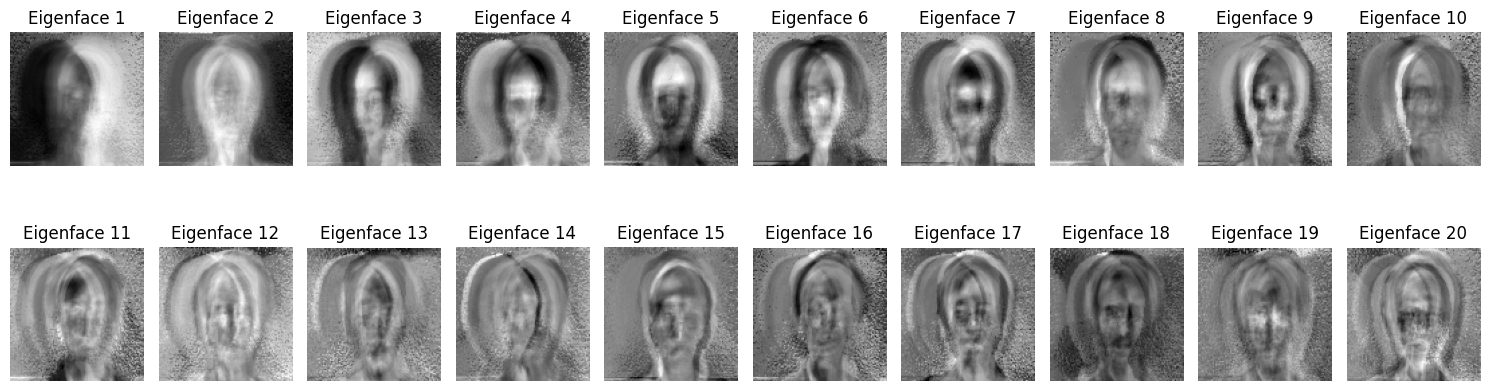

In [140]:
# Hiển thị eigenfaces
show_eigenfaces(pca_model, img_shape=(100,100), num_eigenfaces=20)

#### Assignment 3 (2 scores): 
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

In [141]:
# Phân loại và đánh giá
predictions, sims = classify_knn_improved(X_test_pca, X_train_pca, y_train)

y_true = [fname.split('.')[0] for fname in test_filenames]
all_labels = sorted(list(set(y_train)))
if "unknown" in predictions and "unknown" not in all_labels:
    all_labels.append("unknown")

accuracy = sum(p == t for p, t in zip(predictions, y_true)) / len(y_true)
print(f'\nAccuracy: {accuracy * 100:.2f}%')
print(f'Số lượng dự đoán "unknown": {predictions.count("unknown")} trên {len(y_true)} ảnh')


Accuracy: 73.33%
Số lượng dự đoán "unknown": 0 trên 15 ảnh


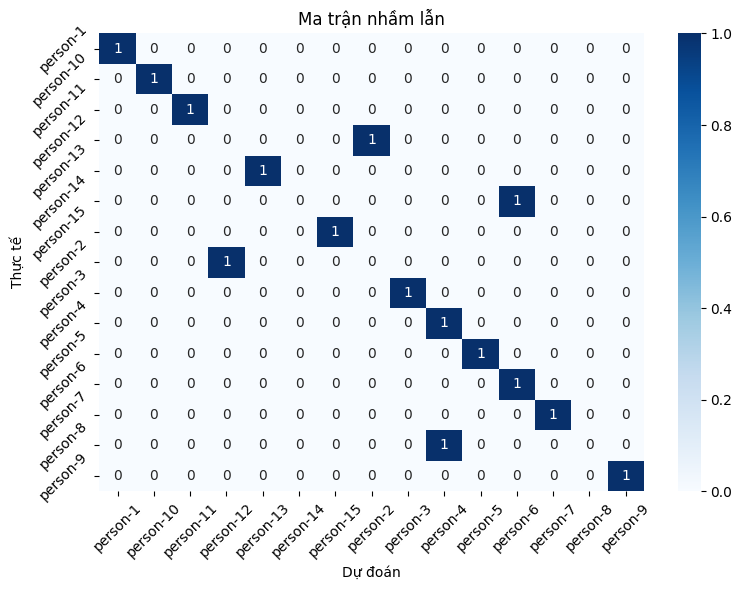

In [142]:
# Confusion matrix
cm = confusion_matrix(y_true, predictions, labels=all_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [143]:
# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_true, predictions, labels=all_labels, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

    person-1       1.00      1.00      1.00         1
   person-10       1.00      1.00      1.00         1
   person-11       1.00      1.00      1.00         1
   person-12       0.00      0.00      0.00         1
   person-13       1.00      1.00      1.00         1
   person-14       0.00      0.00      0.00         1
   person-15       1.00      1.00      1.00         1
    person-2       0.00      0.00      0.00         1
    person-3       1.00      1.00      1.00         1
    person-4       0.50      1.00      0.67         1
    person-5       1.00      1.00      1.00         1
    person-6       0.50      1.00      0.67         1
    person-7       1.00      1.00      1.00         1
    person-8       0.00      0.00      0.00         1
    person-9       1.00      1.00      1.00         1

    accuracy                           0.73        15
   macro avg       0.67      0.73      0.69        15
we

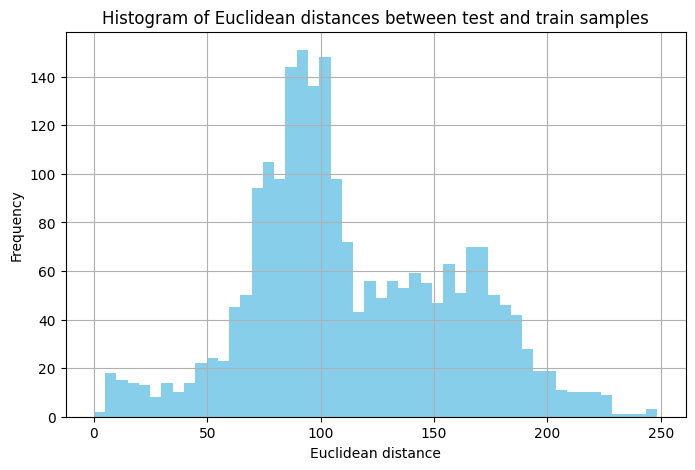

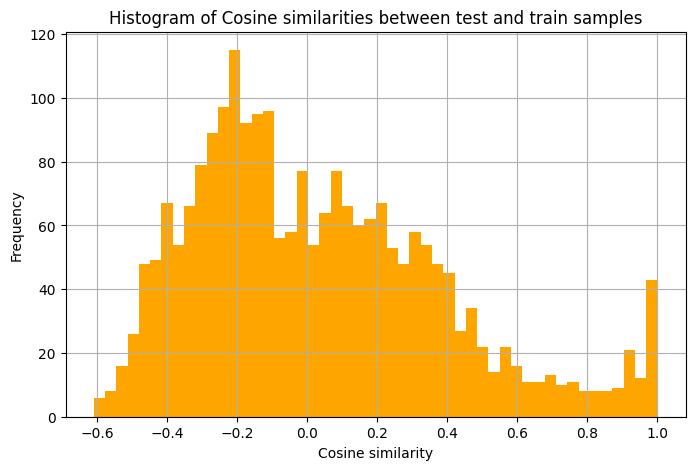

In [144]:
plot_distance_histogram(X_test_pca, X_train_pca, metric='euclidean')
plot_distance_histogram(X_test_pca, X_train_pca, metric='cosine')

In [145]:
# cosine similarity
predictions_cosine, sims_cosine = classify_knn_improved(X_test_pca, X_train_pca, y_train, metric='cosine', threshold=0.4)
accuracy_cosine = np.mean([1 if pred == true else 0 for pred, true in zip(predictions_cosine, y_true) if pred != "unknown"])
print(f'Accuracy (cosine): {accuracy_cosine * 100:.2f}%')

#  Euclidean distance
predictions_euclidean, dists_euclidean = classify_knn_improved(X_test_pca, X_train_pca, y_train, metric='euclidean', threshold=150)
accuracy_euclidean = np.mean([1 if pred == true else 0 for pred, true in zip(predictions_euclidean, y_true) if pred != "unknown"])
print(f'Accuracy (euclidean): {accuracy_euclidean * 100:.2f}%')

Accuracy (cosine): 73.33%
Accuracy (euclidean): 100.00%
